# TEST OF LightGBM

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_parquet('./data/train.parquet')
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662


In [3]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"]) 

In [4]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

## Example of mask

## Using external data

In [5]:
df_ext = pd.read_csv(Path('submissions') / 'starting_kit' / 'external_data copy.csv')
df_ext.head()

,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,...,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,confi,holiday
0,0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,...,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,...,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN,0,1
3,3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,...,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,...,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN,0,1


You can find the detailed documentation for each feature [in this PDF](https://donneespubliques.meteofrance.fr/client/document/doc_parametres_synop_168.pdf) (in French). Here the only feature we consider is the temperature. We will use [pandas.merge_asof](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.merge_asof.html) to merge on date, using the closest available date (since the sampling between the external data and the counter data).

In [6]:
# In this notebook we define the __file__ variable to be in the same conditions as when running the
# RAMP submission

__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'


def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data copy.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't', 'u', 'rr24', 'rr3', 'tend24', 'holiday']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
    

In [7]:
X_train_merge = _merge_external_data(X_train)
columns_merge = X_train_merge.columns
X_train_merge

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,t,u,rr24,rr3,tend24,holiday
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,285.75,81,0.0,0.0,120.0,0
30,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,285.75,81,0.0,0.0,120.0,0
31,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,285.75,81,0.0,0.0,120.0,0
32,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,285.75,81,0.0,0.0,120.0,0
33,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,285.75,81,0.0,0.0,120.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455129,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-08-09 23:00:00,2020-02-18,YTH19111508,48.842010,2.367290,291.45,72,-0.1,0.0,160.0,1
455130,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440,291.45,72,-0.1,0.0,160.0,1
455119,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440,291.45,72,-0.1,0.0,160.0,1
455136,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-08-09 23:00:00,2017-12-15,Y2H21025335,48.848400,2.275860,291.45,72,-0.1,0.0,160.0,1


In [8]:
def confinement(X):
    date = pd.to_datetime(X['date'])
    X.loc[:, ['date_only']] = date
    new_date = [dt.date() for dt in X['date_only']]
    X.loc[:, ['date_only']] = new_date
    mask = ((X['date_only'] >= pd.to_datetime('2020/10/30'))
        & (X['date_only'] <= pd.to_datetime('2020/12/15'))
        | (X['date_only'] >= pd.to_datetime('2021/04/03'))
        & (X['date_only'] <= pd.to_datetime('2021/05/03')))
    X['confi'] = np.where(mask, 1, 0)
    return X

def curfew(X):
    date = pd.to_datetime(X['date'])
    X.loc[:, ['date_only']] = date
    new_date = [dt.date() for dt in X['date_only']]
    X.loc[:, ['date_only']] = new_date
    X.loc[:, ['hour_only']] = date
    new_hour = [dt.hour for dt in X['hour_only']]
    X.loc[:, ['hour_only']] = new_hour
    mask = (
        #First curfew
        (X['date_only'] >= pd.to_datetime('2020/12/15'))
        & (X['date_only'] < pd.to_datetime('2021/01/16'))
        & ((X['hour_only'] >= 20) | (X['hour_only'] <= 6))

        | 
        
        # Second curfew
        (X['date_only'] >= pd.to_datetime('2021/01/16'))
        & (X['date_only'] < pd.to_datetime('2021/03/20'))
        & ((X['hour_only'] >= 18) | (X['hour_only'] <= 6))

        |

        # Third curfew
        (X['date_only'] >= pd.to_datetime('2021/03/20'))
        & (X['date_only'] < pd.to_datetime('2021/05/19'))
        & ((X['hour_only'] >= 19) | (X['hour_only'] <= 6))

        |

        # Fourth curfew
        (X['date_only'] >= pd.to_datetime('2021/05/19'))
        & (X['date_only'] < pd.to_datetime('2021/06/9'))
        & ((X['hour_only'] >= 21) | (X['hour_only'] <= 6))

        |

        # Fifth curfew
        (X['date_only'] >= pd.to_datetime('2021/06/9'))
        & (X['date_only'] < pd.to_datetime('2021/06/20'))
        & ((X['hour_only'] >= 21) | (X['hour_only'] <= 6))
        )
    X['curfew'] = np.where(mask, 1, 0)

    return X.drop(columns=['hour_only', 'date_only'])

def counters_done(X):
    mask1 = (data['counter_name']=='152 boulevard du Montparnasse E-O') & (data['date'] >= pd.to_datetime('2021/01/26')) & (data['date'] <= pd.to_datetime('2021/02/24'))
    mask1bis = (data['counter_name']=='152 boulevard du Montparnasse O-E') & (data['date'] >= pd.to_datetime('2021/01/26')) & (data['date'] <= pd.to_datetime('2021/02/24'))
    mask2 = (data['counter_name']=='20 Avenue de Clichy SE-NO') & (data['date'] >= pd.to_datetime('2021/05/06')) & (data['date'] <= pd.to_datetime('2021/07/21'))
    mask2bis = (data['counter_name']=='20 Avenue de Clichy NO-SE') & (data['date'] >= pd.to_datetime('2021/05/06')) & (data['date'] <= pd.to_datetime('2021/07/21'))
    X.drop(X[mask1].index, inplace=True)
    X.drop(X[mask1bis].index, inplace=True)
    X.drop(X[mask2].index, inplace=True)
    X.drop(X[mask2bis].index, inplace=True)
    return X


Similarly we can wrap this function into a FunctionTranformer to use it in a scikit-learn pipeline. Now let's see whether this additional feature improves the model,

In [10]:
date_encoder = FunctionTransformer(_encode_dates)

confinement_encoder = FunctionTransformer(confinement)
curfew_encoder = FunctionTransformer(curfew)
counters_done_encoder = FunctionTransformer(counters_done)
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
poly_encoder = PolynomialFeatures(degree=2)

categorical_cols = ["counter_name"]
period_cols = ['confi', 'curfew']
date_cols = ['day', 'year', 'weekday', 'month']
hour_col = ['hour']
numeric_cols = ['t', 'u', 'rr24']

preprocessor = ColumnTransformer(
    [
        ("date", StandardScaler(), date_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ('numeric', StandardScaler(), numeric_cols),
        ('period', 'passthrough', period_cols),
        ('hour', PolynomialFeatures(degree=2), hour_col)
    ]
)
regressor = lgb.LGBMRegressor()

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    confinement_encoder,
    curfew_encoder,
    date_encoder,
    preprocessor,
    regressor
)

In [11]:
pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7fb4ec89d9d0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function confinement at 0x7fb4ec89d790>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function curfew at 0x7fb4ec89daf0>)),
                ('functiontransformer-4',
                 FunctionTransformer(func=<function _...ca0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date', StandardScaler(),
                                                  ['day', 'year', 'weekday',
                                                   'month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name']),
                                     

# Parameters tuning : LGBRegressor

Important parameters : https://www.kaggle.com/bextuychiev/lgbm-optuna-hyperparameter-tuning-w-understanding

Control over the tree structure :
 - num_leaves
 - max_depth
 - min_data_in_leaf

 Improve the accuracy :
 - learning_rate and n_estimators, best combination
 - max_bin (default = 255), can improve but risk of overfitting

 Control overfitting :
 - lambda_1 and lambda_2
 - min_gain_to_split

In [12]:
# Get the params
pipe.get_params()

{'memory': None,
 'steps': [('functiontransformer-1',
   FunctionTransformer(func=<function _merge_external_data at 0x7fb4ec89d9d0>)),
  ('functiontransformer-2',
   FunctionTransformer(func=<function confinement at 0x7fb4ec89d790>)),
  ('functiontransformer-3',
   FunctionTransformer(func=<function curfew at 0x7fb4ec89daf0>)),
  ('functiontransformer-4',
   FunctionTransformer(func=<function _encode_dates at 0x7fb4ec800ca0>)),
  ('columntransformer',
   ColumnTransformer(transformers=[('date', StandardScaler(),
                                    ['day', 'year', 'weekday', 'month']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['counter_name']),
                                   ('numeric', StandardScaler(),
                                    ['t', 'u', 'rr24']),
                                   ('period', 'passthrough', ['confi', 'curfew']),
                                   ('hour', PolynomialFeatures(),

In [21]:
from os import pread
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
 
 
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
 
    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
 
def counters_done(X):
    mask1 = (X['counter_name']=='152 boulevard du Montparnasse E-O') & (X['date'] >= pd.to_datetime('2021/01/26')) & (X['date'] <= pd.to_datetime('2021/02/24'))
    X.drop(X[mask1].index, inplace=True)
    mask1bis = (X['counter_name']=='152 boulevard du Montparnasse O-E') & (X['date'] >= pd.to_datetime('2021/01/26')) & (X['date'] <= pd.to_datetime('2021/02/24'))
    X.drop(X[mask1bis].index, inplace=True)
    mask2 = (X['counter_name']=='20 Avenue de Clichy SE-NO') & (X['date'] >= pd.to_datetime('2021/05/06')) & (X['date'] <= pd.to_datetime('2021/07/21'))
    X.drop(X[mask2].index, inplace=True)
    mask2bis = (X['counter_name']=='20 Avenue de Clichy NO-SE') & (X['date'] >= pd.to_datetime('2021/05/06')) & (X['date'] <= pd.to_datetime('2021/07/21'))
    X.drop(X[mask2bis].index, inplace=True)
    return X

 
def confinement(X):
    date = pd.to_datetime(X['date'])
    X.loc[:, ['date_only']] = date
    new_date = [dt.date() for dt in X['date_only']]
    X.loc[:, ['date_only']] = new_date
    mask = ((X['date_only'] >= pd.to_datetime('2020/10/30').date())
        & (X['date_only'] <= pd.to_datetime('2020/12/15').date())
        | (X['date_only'] >= pd.to_datetime('2021/04/03').date())
        & (X['date_only'] <= pd.to_datetime('2021/05/03').date()))
    X['confi'] = np.where(mask, 1, 0)
    return X
 
def curfew(X):
    date = pd.to_datetime(X['date'])
    X.loc[:, ['date_only']] = date
    new_date = [dt.date() for dt in X['date_only']]
    X.loc[:, ['date_only']] = new_date
    X.loc[:, ['hour_only']] = date
    new_hour = [dt.hour for dt in X['hour_only']]
    X.loc[:, ['hour_only']] = new_hour
    mask = (
        #First curfew
        (X['date_only'] >= pd.to_datetime('2020/12/15').date())
        & (X['date_only'] < pd.to_datetime('2021/01/16').date())
        & ((X['hour_only'] >= 20) | (X['hour_only'] <= 6))
 
        | 
        
        # Second curfew
        (X['date_only'] >= pd.to_datetime('2021/01/16').date())
        & (X['date_only'] < pd.to_datetime('2021/03/20').date())
        & ((X['hour_only'] >= 18) | (X['hour_only'] <= 6))
 
        |
 
        # Third curfew
        (X['date_only'] >= pd.to_datetime('2021/03/20').date())
        & (X['date_only'] < pd.to_datetime('2021/05/19').date())
        & ((X['hour_only'] >= 19) | (X['hour_only'] <= 6))
 
        |
 
        # Fourth curfew
        (X['date_only'] >= pd.to_datetime('2021/05/19').date())
        & (X['date_only'] < pd.to_datetime('2021/06/9').date())
        & ((X['hour_only'] >= 21) | (X['hour_only'] <= 6))
 
        |
 
        # Fifth curfew
        (X['date_only'] >= pd.to_datetime('2021/06/9').date())
        & (X['date_only'] < pd.to_datetime('2021/06/20').date())
        & ((X['hour_only'] >= 21) | (X['hour_only'] <= 6))
        )
    X['curfew'] = np.where(mask, 1, 0)
 
    return X.drop(columns=['hour_only', 'date_only'])
 
 
def _merge_external_data(X):
    file_path = './external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date','t','u', 'rr3']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
 
 
 
def get_estimator():
    confinement_encoder = FunctionTransformer(confinement)
    curfew_encoder = FunctionTransformer(curfew)
    date_encoder = FunctionTransformer(_encode_dates)
    merge = FunctionTransformer(_merge_external_data, validate=False)
    counters = FunctionTransformer(counters_done)
 
    date_cols = ['month', 'day', 'weekday', 'year']
 
    categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=100)
    categorical_cols = ["counter_name"]
    numeric_cols = ['t','u']
    period_cols = ['confi', 'curfew']
    hour_col = ['hour']
 
    preprocessor = ColumnTransformer(
        [
            ("date", StandardScaler(), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ('numeric', StandardScaler(), numeric_cols),
            ('period', 'passthrough', period_cols),
            ('hour', PolynomialFeatures(degree=2), hour_col)
        ]
    )

    params1 = {
        'colsample_bytree': 0.7,
        'learning_rate': 0.01,
        'max_depth': -1,
        'min_child_samples': 198,
        'min_child_weight': 0.1,
        'n_estimators': 2000,
        'num_leaves': 47,
        'reg_alpha': 1,
        'reg_lambda': 0.1,
        'subsample': 0.5
    }

    regressor = lgb.LGBMRegressor(**params1, random_state=21)
    pipe = make_pipeline(merge, confinement_encoder, curfew_encoder, date_encoder, preprocessor, regressor)
 
    return pipe
 

In [23]:
X_train

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,Y2H20073268,48.885290,2.326660
...,...,...,...,...,...,...,...,...,...
794577,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-08-09 23:00:00,2020-02-18,YTH19111508,48.842010,2.367290
804787,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440
814377,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440
125899,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-08-09 23:00:00,2017-12-15,Y2H21025335,48.848400,2.275860


Text(0, 0.5, 'bike_count')

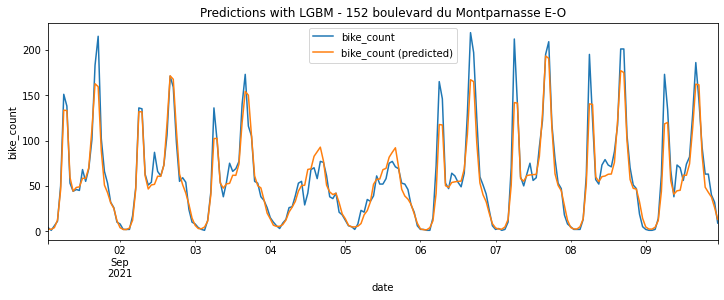

In [25]:
pipe = get_estimator()
pipe.fit(X_train, y_train)

mask = ((X_test['counter_name'] == '152 boulevard du Montparnasse E-O')
        & (X_test['date'] > pd.to_datetime('2021/09/01'))
        & (X_test['date'] < pd.to_datetime('2021/09/15')))
df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1
fig, ax = plt.subplots(figsize=(12, 4))
df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax)
ax.set_title('Predictions with LGBM - 152 boulevard du Montparnasse E-O')
ax.set_ylabel('bike_count')

## <p style='color: orange;'>Control over the tree structure</p>

In [14]:
# Tuning max depth => num_leaves => min_data_in_leaf
from sklearn.model_selection import GridSearchCV

# Latest = Best params : {'lgbmregressor__max_depth': 6, 'lgbmregressor__min_data_in_leaf': 20, 'lgbmregressor__num_leaves': 64}
#"data": "Best params : {'lgbmregressor__learning_rate': 0.1,
#  'lgbmregressor__max_depth': 24,
#  'lgbmregressor__min_data_in_leaf': 200,
#  'lgbmregressor__min_gain_to_split': 0,
#  'lgbmregressor__n_estimators': 200,
#  'lgbmregressor__num_leaves': 1024,
#  'lgbmregressor__reg_alpha': 4,
#  'lgbmregressor__reg_lambda': 4}\n"


# 1ST PART CONTROL OVER TREE STRUCTURE

params = {
    'lgbmregressor__max_depth': [6,24],
    'lgbmregressor__num_leaves': [2**6, 2**10],
    'lgbmregressor__min_data_in_leaf':[40, 200],
    'lgbmregressor__n_estimators': [130, 200],
}

grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)
result_gs = grid_search.fit(X_train, y_train)
print(f"Best params : {result_gs.best_params_}")

# 1st try 
    #'lgbmregressor__max_depth': [4, 6, 12],
        # 'The maximum limit to num_leaves should be 2^(max_depth)'
    #'lgbmregressor__num_leaves': [2**4, 2**5, 2**10],
        #  Setting min_data_in_leaf to 100 means we want to evaluate this leaf only if at least 100 training observations respect a condition at the leaf
    #'lgbmregressor__min_data_in_leaf':[1000, 1200, 1500]

    #Best params : {'lgbmregressor__max_depth': 12, 'lgbmregressor__min_data_in_leaf': 1000, 'lgbmregressor__num_leaves': 1024}

# 2nd try 
    #'lgbmregressor__max_depth': [12, 24],
    #'lgbmregressor__num_leaves': [2**10, 2**14],
    #'lgbmregressor__min_data_in_leaf':[500, 1000]

    # Best params : {'lgbmregressor__max_depth': 24, 'lgbmregressor__min_data_in_leaf': 500, 'lgbmregressor__num_leaves': 1024}

# 3rd try 
    #'lgbmregressor__max_depth': [24, 40],
    #'lgbmregressor__num_leaves': [2**10, 2**12],
    #'lgbmregressor__min_data_in_leaf':[300, 500, 800]
    # Best params : {'lgbmregressor__max_depth': 24, 'lgbmregressor__min_data_in_leaf': 300, 'lgbmregressor__num_leaves': 1024}

# 4th try 
    #'lgbmregressor__max_depth': [24, 30],
    #'lgbmregressor__num_leaves': [2**8, 2**10],
    #'lgbmregressor__min_data_in_leaf':[100, 300]
    # Best params : {'lgbmregressor__max_depth': 24, 'lgbmregressor__min_data_in_leaf': 100, 'lgbmregressor__num_leaves': 1024}

# 5th try
    #'lgbmregressor__max_depth': [20, 24],
    #'lgbmregressor__num_leaves': [2**9, 2**10],
    #'lgbmregressor__min_data_in_leaf':[70, 100, 150]
    #Best params : {'lgbmregressor__max_depth': 24, 'lgbmregressor__min_data_in_leaf': 70, 'lgbmregressor__num_leaves': 1024}

# 6th try
    #'lgbmregressor__max_depth': [24],
    #'lgbmregressor__num_leaves': [2**10],
    #'lgbmregressor__min_data_in_leaf':[40, 70, 80]
    # Best : 40

#7th try 
    #'lgbmregressor__min_data_in_leaf':[30, 40]
    #Best : 40





/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to mat

Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/7l/vp4hkxqx6m9901fw5fydkvww0000gn/T/ipykernel_68293/1883852333.py", line 26, in <module>
    result_gs = grid_search.fit(X_train, y_train)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1296, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/si

TypeError: object of type 'NoneType' has no len()

## LATEST : Best params : {'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__max_bin': 340, 'lgbmregressor__max_depth': 6, 'lgbmregressor__min_data_in_leaf': 30, 'lgbmregressor__n_estimators': 50, 'lgbmregressor__num_leaves': 64}

## <p style='color: orange;'>Better accuracy</p>

In [ ]:
# Tuning learning_rate and n_estimators



params = {
    'lgbmregressor__max_depth': [6],
    'lgbmregressor__num_leaves': [64],
    'lgbmregressor__min_data_in_leaf':[30],
}

grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=4, cv=5)
result_gs = grid_search.fit(X_train, y_train)
print(f"Best params : {result_gs.best_params_}")


# First try
# 0.1 0.15
 #Best params : {'lgbmregressor__max_depth': 24, 'lgbmregressor__min_data_in_leaf': 40, 'lgbmregressor__num_leaves': 1024}

# 2nd try
    #'lgbmregressor__learning_rate':[0.9, 0.1],
    #'lgbmregressor__n_estimators': [85, 100, 115],
    # Best params : {'lgbmregressor__max_depth': 24, 'lgbmregressor__min_data_in_leaf': 40, 'lgbmregressor__num_leaves': 1024}

#3rd try
    #'lgbmregressor__learning_rate':[0.1, 0.13],
    #'lgbmregressor__n_estimators': [100, 115, 130],

    #Best 0.1 and 130

# 4th try
    #'lgbmregressor__n_estimators': [130, 150, 170],
    # Best = 130

## <p style='color: orange;'>Other parameters to control overfitting</p>

In [ ]:
params = {
    'lgbmregressor__max_depth': [6],
    'lgbmregressor__num_leaves': [64],
    'lgbmregressor__min_data_in_leaf':[30],
    'lgbmregressor__learning_rate':[0.05],
    'lgbmregressor__n_estimators': [50],
    'lgbmregressor__max_bin': [340],

    # lambda_l1 and lambda_l2 specifies L1 or L2 regularization, the optimal value for these parameters is harder to tune because their magnitude is not directly correlated with overfitting. However, a good search range is (0, 100) for both.
    'lgbmregressor__lambda_l1': [0, 0.1, 1, 10] ,
    'lgbmregressor__lambda_l2': [0, 0.1, 1, 10],

    # A conservative search range is (0, 15). It can be used as extra regularization in large parameter grids.
    'lgbmregressor__min_gain_to_split':[0, 8, 15]
    
    
}

grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=4, cv=5)
result_gs = grid_search.fit(X_train, y_train)
print(f"Best params : {result_gs.best_params_}")

## New tuning

In [2]:
# Tuning learning_rate and n_estimators

## LATEST : Best params : {'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__max_bin': 340, 'lgbmregressor__max_depth': 6, 'lgbmregressor__min_data_in_leaf': 30, 'lgbmregressor__n_estimators': 50, 'lgbmregressor__num_leaves': 64}

params = {

'lgbmregressor__learning_rate': [0.01],
'lgbmregressor__max_depth': [10], 
'lgbmregressor__min_child_samples': [200], 
'lgbmregressor__min_split_gain': [0], 
'lgbmregressor__n_estimators': [250], 
'lgbmregressor__num_leaves': [600], 
'lgbmregressor__reg_alpha': [0],
'lgbmregressor__reg_lambda': [2]
}

grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=4, cv=5)
result_gs = grid_search.fit(X_train, y_train)
print(f"Best params : {result_gs.best_params_}")



NameError: name 'GridSearchCV' is not defined

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

params = {

'lgbmregressor__learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
'lgbmregressor__n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
'lgbmregressor__num_leaves': sp_randint(6, 50), 
'lgbmregressor__min_child_samples': sp_randint(100, 500), 
'lgbmregressor__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
'lgbmregressor__subsample': [0.2, 0.5, 0.7, 0.9],
'lgbmregressor__max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
'lgbmregressor__colsample_bytree': [0.2, 0.5, 0.7, 0.9],
'lgbmregressor__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
'lgbmregressor__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]

}

grid_search = RandomizedSearchCV(pipe, param_distributions=params, n_jobs=4, cv=5, random_state=42, scoring='neg_mean_squared_error', n_iter=200)
result_gs = grid_search.fit(X_train, y_train)
print(f"Best params : {result_gs.best_params_}")

ERROR! Session/line number was not unique in database. History logging moved to new session 405


/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to mat

Best params : {'lgbmregressor__colsample_bytree': 0.7, 'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': -1, 'lgbmregressor__min_child_samples': 198, 'lgbmregressor__min_child_weight': 0.1, 'lgbmregressor__n_estimators': 2000, 'lgbmregressor__num_leaves': 47, 'lgbmregressor__reg_alpha': 1, 'lgbmregressor__reg_lambda': 0.1, 'lgbmregressor__subsample': 0.5}


In [100]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we